In [81]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from prophet import Prophet
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
from xgboost import XGBRegressor
import joblib

# Better plots
plt.style.use('seaborn-v0_8-darkgrid')

In [82]:
# Load dataset
df = pd.read_csv('/content/sales_data_sample.csv', encoding='latin1')

# Show shape & head
print(f"Data shape: {df.shape}")
df.head()

Data shape: (2823, 25)


,ORDERNUMBER,QUANTITYORDERED,PRICEEACH,ORDERLINENUMBER,SALES,ORDERDATE,STATUS,QTR_ID,MONTH_ID,YEAR_ID,...,ADDRESSLINE1,ADDRESSLINE2,CITY,STATE,POSTALCODE,COUNTRY,TERRITORY,CONTACTLASTNAME,CONTACTFIRSTNAME,DEALSIZE
0,10107,30,95.70,2,2871.00,2/24/2003 0:00,Shipped,1,2,2003,...,897 Long Airport Avenue,NaN,NYC,NY,10022,USA,NaN,Yu,Kwai,Small
1,10121,34,81.35,5,2765.90,5/7/2003 0:00,Shipped,2,5,2003,...,59 rue de l'Abbaye,NaN,Reims,NaN,51100,France,EMEA,Henriot,Paul,Small
2,10134,41,94.74,2,3884.34,7/1/2003 0:00,Shipped,3,7,2003,...,27 rue du Colonel Pierre Avia,NaN,Paris,NaN,75508,France,EMEA,Da Cunha,Daniel,Medium
3,10145,45,83.26,6,3746.70,8/25/2003 0:00,Shipped,3,8,2003,...,78934 Hillside Dr.,NaN,Pasadena,CA,90003,USA,NaN,Young,Julie,Medium
4,10159,49,100.00,14,5205.27,10/10/2003 0:00,Shipped,4,10,2003,...,7734 Strong St.,NaN,San Francisco,CA,NaN,USA,NaN,Brown,Julie,Medium


In [83]:
# Show info & stats
print(df.info())
print(df.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2823 entries, 0 to 2822
Data columns (total 25 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   ORDERNUMBER       2823 non-null   int64  
 1   QUANTITYORDERED   2823 non-null   int64  
 2   PRICEEACH         2823 non-null   float64
 3   ORDERLINENUMBER   2823 non-null   int64  
 4   SALES             2823 non-null   float64
 5   ORDERDATE         2823 non-null   object 
 6   STATUS            2823 non-null   object 
 7   QTR_ID            2823 non-null   int64  
 8   MONTH_ID          2823 non-null   int64  
 9   YEAR_ID           2823 non-null   int64  
 10  PRODUCTLINE       2823 non-null   object 
 11  MSRP              2823 non-null   int64  
 12  PRODUCTCODE       2823 non-null   object 
 13  CUSTOMERNAME      2823 non-null   object 
 14  PHONE             2823 non-null   object 
 15  ADDRESSLINE1      2823 non-null   object 
 16  ADDRESSLINE2      302 non-null    object 


In [84]:
# Count missing values
missing_counts = df.isnull().sum()
missing_percent = (missing_counts / len(df)) * 100

# Combine into DataFrame for clarity
missing_df = pd.DataFrame({
    'Missing Values': missing_counts,
    'Percentage (%)': missing_percent.round(2)
})

# Filter only columns with missing values
missing_df = missing_df[missing_df['Missing Values'] > 0]

print("📋 Columns with missing values:")
print(missing_df)

📋 Columns with missing values:
              Missing Values  Percentage (%)
ADDRESSLINE2            2521           89.30
STATE                   1486           52.64
POSTALCODE                76            2.69
TERRITORY               1074           38.04


In [85]:
# Drop high-missing columns not useful for forecasting
df = df.drop(columns=['ADDRESSLINE2', 'STATE', 'TERRITORY'])

#Fill missing POSTALCODE with 'Unknown'
df['POSTALCODE'] = df['POSTALCODE'].fillna('Unknown')

print("✅ Cleaned data: dropped ADDRESSLINE2, STATE, TERRITORY; filled POSTALCODE with 'Unknown'")

✅ Cleaned data: dropped ADDRESSLINE2, STATE, TERRITORY; filled POSTALCODE with 'Unknown'


/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) Liberation Sans.
  fig.canvas.print_figure(bytes_io, **kw)


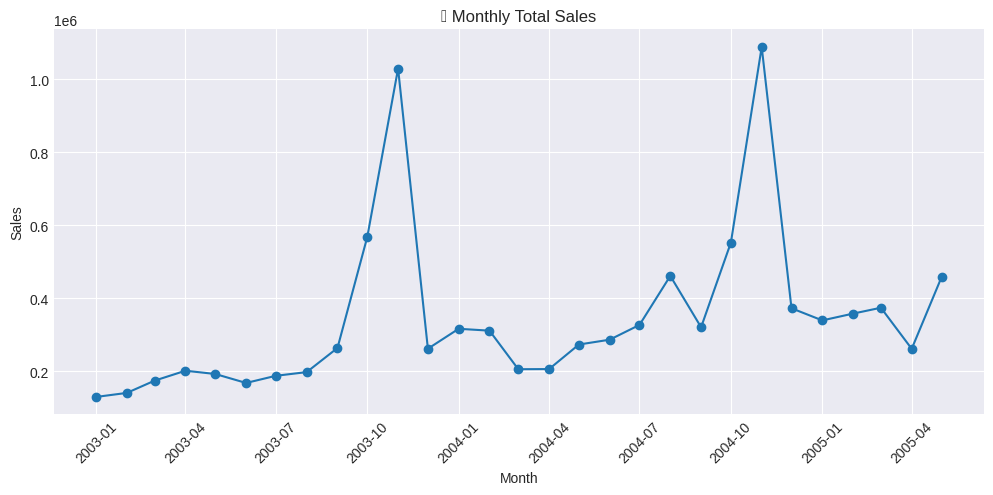

In [86]:
df['ORDERDATE'] = pd.to_datetime(df['ORDERDATE'])
df['Month'] = df['ORDERDATE'].dt.to_period('M')

monthly_sales = df.groupby('Month')['SALES'].sum().reset_index()
monthly_sales['Month'] = monthly_sales['Month'].dt.to_timestamp()

# Plot sales over time
plt.figure(figsize=(12,5))
plt.plot(monthly_sales['Month'], monthly_sales['SALES'], marker='o')
plt.title('📈 Monthly Total Sales')
plt.xlabel('Month')
plt.ylabel('Sales')
plt.xticks(rotation=45)
plt.show()

In [87]:
monthly_sales['Month_num'] = np.arange(len(monthly_sales)) + 1
monthly_sales['Month_of_year'] = monthly_sales['Month'].dt.month
monthly_sales['Quarter'] = monthly_sales['Month'].dt.quarter

monthly_sales.tail()

,Month,SALES,Month_num,Month_of_year,Quarter
24,2005-01-01,339543.42,25,1,1
25,2005-02-01,358186.18,26,2,1
26,2005-03-01,374262.76,27,3,1
27,2005-04-01,261633.29,28,4,2
28,2005-05-01,457861.06,29,5,2


In [88]:
df_prophet = monthly_sales[['Month', 'SALES']].rename(columns={'Month': 'ds', 'SALES': 'y'})

train_df_prophet = df_prophet[:-6]
test_df_prophet = df_prophet[-6:]

prophet_model = Prophet()
prophet_model.fit(train_df_prophet)

future = prophet_model.make_future_dataframe(periods=6, freq='M')
forecast = prophet_model.predict(future)
forecast_test = forecast[-6:]

/usr/local/lib/python3.11/dist-packages/prophet/forecaster.py:1872: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  dates = pd.date_range(


/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) Liberation Sans.
  fig.canvas.print_figure(bytes_io, **kw)


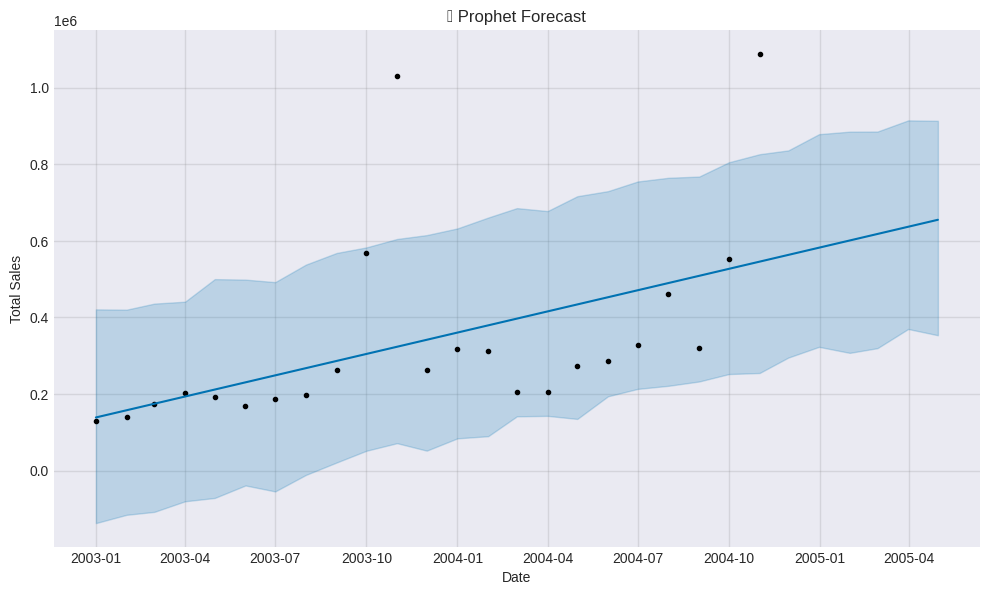

In [89]:
fig = prophet_model.plot(forecast)
plt.title('📊 Prophet Forecast')
plt.xlabel('Date')
plt.ylabel('Total Sales')
plt.show()

In [90]:
mse_p = mean_squared_error(test_df_prophet['y'], forecast_test['yhat'])
mae_p = mean_absolute_error(test_df_prophet['y'], forecast_test['yhat'])
mape_p = mean_absolute_percentage_error(test_df_prophet['y'], forecast_test['yhat'])

print("✅ Prophet Performance:")
print(f"MSE: {mse_p:.0f} | MAE: {mae_p:.0f} | MAPE: {mape_p:.2%}")

✅ Prophet Performance:
MSE: 65551733698 | MAE: 248722 | MAPE: 73.67%


In [91]:
# One-hot encode categorical features
monthly_sales_encoded = pd.get_dummies(monthly_sales, columns=['Month_of_year', 'Quarter'])

feature_cols = [c for c in monthly_sales_encoded.columns if c not in ['Month', 'SALES']]
X = monthly_sales_encoded[feature_cols]
y = monthly_sales_encoded['SALES']

X_train, X_test = X[:-6], X[-6:]
y_train, y_test = y[:-6], y[-6:]


In [92]:
xgb_model = XGBRegressor(n_estimators=100, random_state=42)
xgb_model.fit(X_train, y_train)

predictions_xgb = xgb_model.predict(X_test)

In [93]:
mse_xgb = mean_squared_error(y_test, predictions_xgb)
mae_xgb = mean_absolute_error(y_test, predictions_xgb)
mape_xgb = mean_absolute_percentage_error(y_test, predictions_xgb)

print("✅ XGBoost Performance:")
print(f"MSE: {mse_xgb:.0f} | MAE: {mae_xgb:.0f} | MAPE: {mape_xgb:.2%}")

✅ XGBoost Performance:
MSE: 4908653018 | MAE: 59259 | MAPE: 15.95%


/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) Liberation Sans.
  fig.canvas.print_figure(bytes_io, **kw)


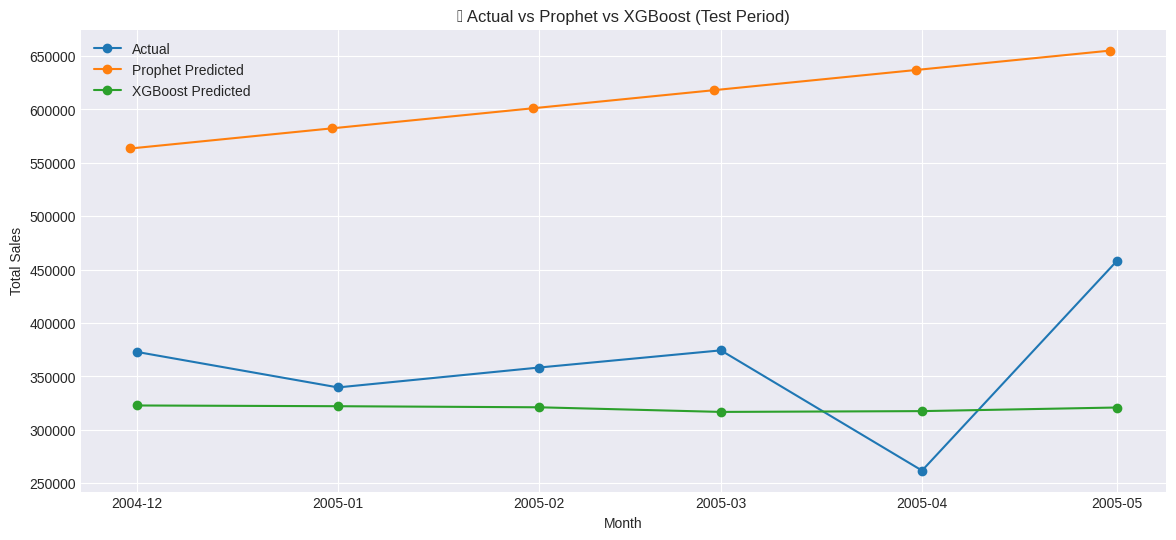

In [94]:
plt.figure(figsize=(14,6))
plt.plot(monthly_sales['Month'][-6:], y_test.values, label='Actual', marker='o')
plt.plot(forecast_test['ds'], forecast_test['yhat'], label='Prophet Predicted', marker='o')
plt.plot(monthly_sales['Month'][-6:], predictions_xgb, label='XGBoost Predicted', marker='o')
plt.title('📊 Actual vs Prophet vs XGBoost (Test Period)')
plt.xlabel('Month')
plt.ylabel('Total Sales')
plt.legend()
plt.show()

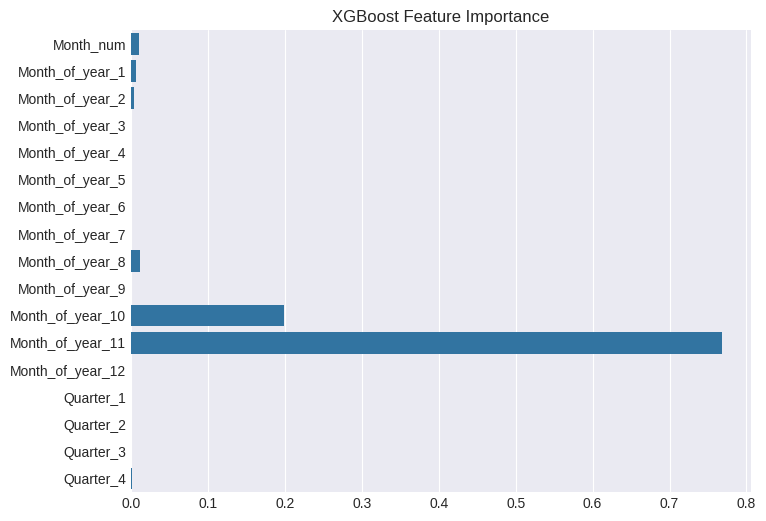

In [95]:
plt.figure(figsize=(8,6))
sns.barplot(x=xgb_model.feature_importances_, y=feature_cols)
plt.title('XGBoost Feature Importance')
plt.show()

In [96]:
joblib.dump(prophet_model, 'prophet_model.pkl')
joblib.dump(xgb_model, 'xgboost_sales_forecast.pkl')
print("✅ Models saved: prophet_model.pkl & xgboost_sales_forecast.pkl")

✅ Models saved: prophet_model.pkl & xgboost_sales_forecast.pkl


In [97]:
results = pd.DataFrame({
    'Model': ['Prophet', 'XGBoost'],
    'MSE': [mse_p, mse_xgb],
    'MAE': [mae_p, mae_xgb],
    'MAPE': [mape_p, mape_xgb]
})

print("📊 Comparative Results:")
print(results)

print("""
✅ XGBoost performs better due to:
- Nonlinear spikes modeling
- Use of calendar features
- Handles few data points better

🎉 Prophet is good at smooth seasonal trends, but struggles with large spikes.
""")


📊 Comparative Results:
     Model           MSE            MAE      MAPE
0  Prophet  6.555173e+10  248721.882441  0.736699
1  XGBoost  4.908653e+09   59259.209792  0.159499

✅ XGBoost performs better due to:
- Nonlinear spikes modeling
- Use of calendar features
- Handles few data points better

🎉 Prophet is good at smooth seasonal trends, but struggles with large spikes.

